# Visual Quality Control
In this notebook, we build an anomaly detection model for images that can be used for visual quality control. The implementation is based on [1] and [2].

### Data
We use `MVTec AD` dataset. See `datasets.md` for details.

### References
  1. https://github.com/PabloMaj/Unsupervised-Anomaly-Detection-with-SSIM-AE
  2. Bergmann, Paul, et al. -- Improving unsupervised defect segmentation by applying structural similarity to autoencoders, 2018

In [11]:

import cv2
import os
import numpy as np
import random
import warnings
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

2.17.0


# Read and Visualize the Data

We start with reading and visualizing normal and anomalous image instances for several categories.

In [12]:
data_basedir = 'mvtec_anomaly_detection'

def read_data(dataset_name, data_basedir):
    path_to_train_set = f'{data_basedir}/{dataset_name}/train/'
    path_to_test_set = f'{data_basedir}/{dataset_name}/test/'

    train_data = {}
    test_data = {}

    region_extracted_size = (256, 256)
    region_resized_size = (128, 128)

    for path_to_data, data_dict in [(path_to_train_set, train_data), (path_to_test_set, test_data)]:
        for category in os.listdir(path_to_data):
            for img_name in os.listdir(path_to_data + str(category)):

                img = cv2.imread(f'{path_to_data}{category}/{img_name}', 0)
                for x_start in range(0, img.shape[0]-region_extracted_size[0]+1, region_extracted_size[0]):
                    for y_start in range(0, img.shape[1]-region_extracted_size[1]+1, region_extracted_size[1]):

                        x_end = x_start + region_extracted_size[0]
                        y_end = y_start + region_extracted_size[1]

                        img_region = img[x_start:x_end, y_start:y_end]
                        img_resized = cv2.resize(img_region, region_resized_size)
                        img_resized = img_resized.astype("float32") / 255.0

                        if category not in data_dict:
                            data_dict[category] = dict()
                        if img_name not in data_dict[category]:
                            data_dict[category][img_name] = []
                        data_dict[category][img_name].append(img_resized)

    return train_data, test_data


data = {
    'grid': read_data('grid', data_basedir),
    'carpet': read_data('carpet', data_basedir),
    'hazelnut': read_data('hazelnut', data_basedir)
}

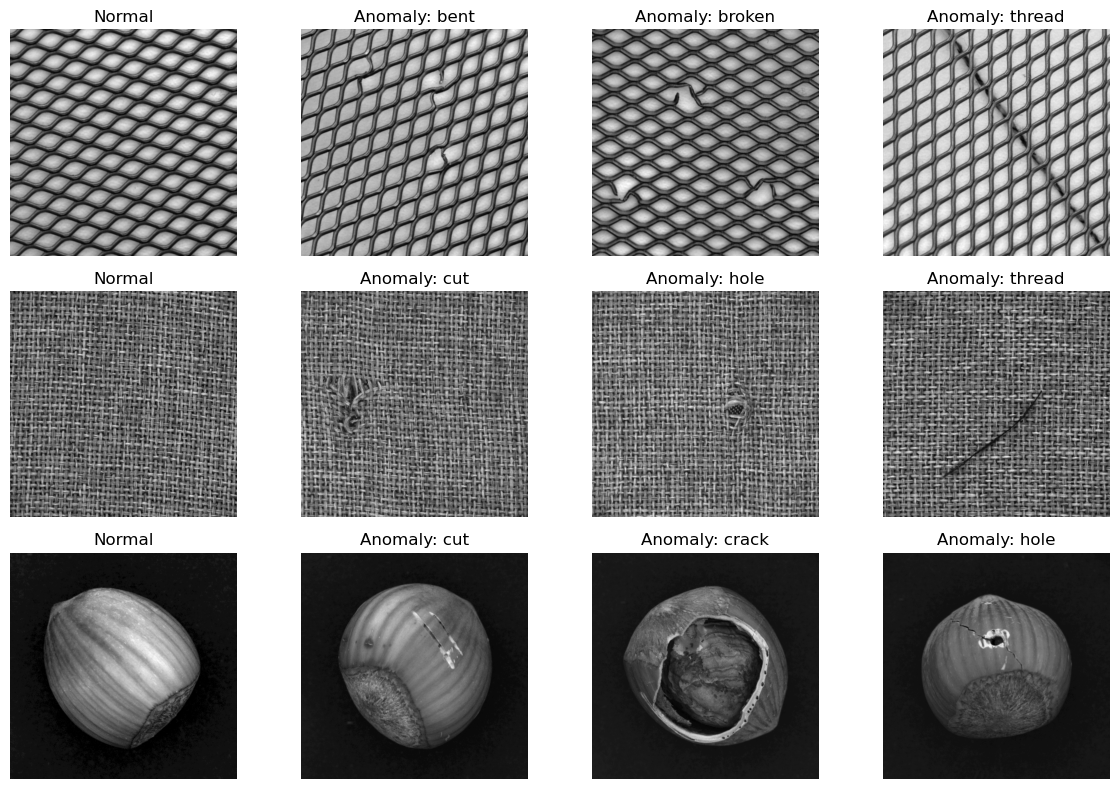

In [13]:
def regions_to_image(regions):
    s = (int)(np.sqrt(len(regions)))
    region_size = regions[0].shape
    image = np.zeros((region_size[0]*s, region_size[1]*s))
    for i in range(0, s):
        for j in range(0, s):
            image[i*region_size[0] : (i+1)*region_size[0], 
                  j*region_size[1] : (j+1)*region_size[1]] = regions[i*s + j]
    return image

fig, ax = plt.subplots(3, 4, figsize=(12, 8))
sample_spec_grid = [
    (('grid', '001'), ('bent', '011'), ('broken', '001'), ('thread', '009')),
    (('carpet', '001'), ('cut', '000'),  ('hole', '007'),   ('thread', '010')),
    (('hazelnut', '001'), ('cut', '004'),  ('crack', '007'),   ('hole', '010'))
]

for c, spec in enumerate(sample_spec_grid):
    train, test = data[spec[0][0]]
    ax[c, 0].imshow(regions_to_image(train['good'][f'{spec[0][1]}.png']), cmap='gray')
    ax[c, 0].axis('off')
    ax[c, 0].set_title('Normal')
    for i, item in enumerate(spec[1:]):
        ax[c, i+1].imshow(regions_to_image(test[item[0]][f'{item[1]}.png']), cmap='gray')
        ax[c, i+1].axis('off')
        ax[c, i+1].set_title(f'Anomaly: {item[0]}')

plt.tight_layout()
plt.show()

# Create a Data Loader with Augmentation

Next, we create a loader that samples small regions (patches) from images.

In [14]:
def read_data_with_random_crop(dataset_name, data_basedir, N_train=10**4):
    img_resized_size = (512, 512)
    crop_size = (128, 128)

    path_to_train_set = f'{data_basedir}/{dataset_name}/train'
    train_data = []

    for i in range(0, N_train):
        img_name = random.choice(list(os.listdir(path_to_train_set + '/good')))
        img = cv2.imread(f'{path_to_train_set}/good/{img_name}', 0)
        img_resized = cv2.resize(img, img_resized_size)
        x_start = random.randint(0, img_resized.shape[0]-crop_size[0])
        y_start = random.randint(0, img_resized.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        crop = img_resized[x_start:x_end, y_start:y_end]
        crop = crop.astype("float32") / 255.0
        train_data.append(crop)

    X_train = np.array(train_data)

    return X_train

# Specify the Autoencoder Model 

In this section, we specify the autoencoder model, SSIM loss function, and training procedure. 

In [23]:
def autoencoder_model(input_shape=(128, 128, 1), latent_dim=100):
    parameters = dict()
    N_layers = 8
    parameters["filters"] = [32, 32, 32, 64, 64, 128, 64, 32]
    parameters["kernel_size"]    = [4, 4, 3, 4, 3, 4, 3, 3]
    parameters["kernel_size_up"] = [4, 3, 4, 3, 4, 3, 3, 8]
    parameters["strides"]        = [2, 2, 1, 2, 1, 2, 1, 1]
    parameters["strides_up"]     = [2, 1, 2, 1, 2, 1, 1, 8]
    parameters["padding"] = ["same" for _ in range(N_layers)] 

    # Input
    inputs = Input(shape=input_shape)
    x = inputs

    # Encoder
    for i in range(0, N_layers):
        x = Conv2D(
          filters=parameters["filters"][i],
          kernel_size=parameters["kernel_size"][i],
          strides=parameters["strides"][i],
          padding=parameters["padding"][i])(x)
        x = LeakyReLU(alpha=0.2)(x)
        
    x = Conv2D(
          filters=latent_dim,
          kernel_size=8,
          strides=1,
          padding='valid')(x)

    # Decoder
    for i in reversed(range(0, N_layers)):
        x = Conv2DTranspose(
          filters=parameters["filters"][i],
          kernel_size=parameters["kernel_size_up"][i],
          strides=parameters["strides_up"][i],
          padding=parameters["padding"][i])(x)
        x = LeakyReLU(alpha=0.2)(x)

    # Output
    x = Conv2DTranspose(
      filters=input_shape[2],
      kernel_size=(4, 4),
      strides=(2, 2),
      padding="same")(x)

    outputs = x

    # Autoencoder
    autoencoder = Model(inputs, outputs, name='autoencoder')

    return autoencoder

def dssim_loss(y_true, y_pred):
    return 1/2 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))/2

def model_name(dataset_name, latent_dim, training_loss, batch_size):
    return f'{dataset_name}_dim_{latent_dim}_loss_{training_loss}_batch_{batch_size}.hdf5'

def train_model(dataset_name, data_basedir, model_basedir, input_shape=(128, 128, 1), 
                latent_dim=100, training_loss='ssim', random_crop=False, batch_size=8):
    #
    # Read data
    #
    if random_crop:
        X_train = read_data_with_random_crop(dataset_name=dataset_name, data_basedir=data_basedir, N_train=10000)
        X_train = np.expand_dims(X_train, axis=-1)
    else:
        train_data, _ = read_data(dataset_name=dataset_name, data_basedir=data_basedir)
        X_train = []
        for img_name in train_data['good'].keys():
            for img in train_data['good'][img_name]:
                X_train.append(img)
        X_train = np.array(X_train)
        X_train = np.expand_dims(X_train, axis=-1)

    Y_train = X_train
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)
    print(f'Loaded data: train {X_train.shape}, validation {Y_val.shape}')

    #
    # Create autoencoder
    #
    autoencoder = autoencoder_model(input_shape=input_shape, latent_dim=latent_dim)

    #
    # Set training loss function and optimizer
    #
    opt = Adam(learning_rate=2*10e-5)

    if training_loss == 'mse':
        autoencoder.compile(loss='mse', optimizer=opt)
    elif training_loss == 'ssim':
        autoencoder.compile(loss=dssim_loss, optimizer=opt)

    #    
    # Set callbacks
    #
    model_filename = model_name(dataset_name, latent_dim, training_loss, batch_size)
    path_to_save_model = f'{model_basedir}/{model_filename}'

    model_checkpoint_callback = ModelCheckpoint(
      save_weights_only=False, filepath=path_to_save_model,
      monitor='val_loss', save_best_only=True)
    early_stopping_callback = EarlyStopping(
      monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

    #
    # Training
    #
    autoencoder.fit(
      x=X_train, y=Y_train,
      epochs=200, batch_size=batch_size,
      shuffle=True, validation_data=(X_val, Y_val),
      callbacks=[model_checkpoint_callback, early_stopping_callback])

def load_model(dataset_name, model_basedir, input_shape=(128, 128, 1), latent_dim=100, training_loss='ssim', batch_size=8):
    autoencoder = autoencoder_model(input_shape=input_shape, latent_dim=latent_dim)
    
    model_filename = model_name(dataset_name, latent_dim, training_loss, batch_size)
    if model_filename in os.listdir(f'{model_basedir}'):
        autoencoder.load_weights(f'{model_basedir}/{model_filename}')
    else:
        raise FileNotFoundError(f'Model {model_filename} not found')
        
    return autoencoder

# Train the Model

In [24]:
# dataset_name = 'grid'
# latent_dim = 100
# batch_size = 8
# training_loss = 'ssim'
# load_model = False
# random_crop = True

# model_basedir = 'visual-quality-control-models'

# train_model( 
#     dataset_name = dataset_name,
#     data_basedir = data_basedir,
#     model_basedir = model_basedir,
#     input_shape=(128, 128, 1),
#     latent_dim = latent_dim,
#     training_loss = training_loss,
#     load_model = load_model,
#     random_crop = random_crop,
#     batch_size = batch_size)

# Score Anomalies

We read several test images, reconstruct them using the autoencoder, and visualize the loss.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

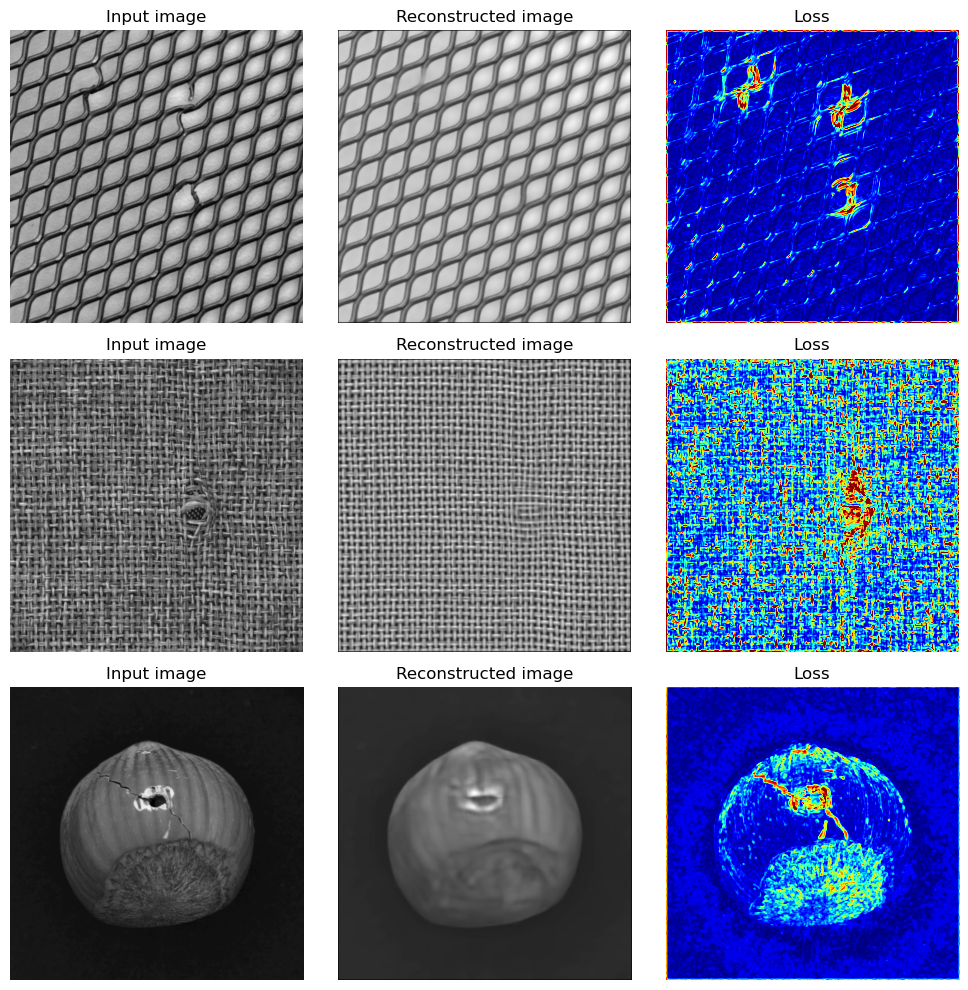

In [32]:
model_basedir = 'mvtec_anomaly_detection'

img_in_size = (1024, 1024)
img_resized_size = (512, 512)
crop_size = (128, 128)
step = 32

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
sample_spec_grid = [
    ('grid', ('bent', '011')),
    ('carpet', ('hole', '007')),
    ('hazelnut', ('hole', '010'))
]

for c, spec in enumerate(sample_spec_grid):
    dataset_name = spec[0]
    autoencoder = load_model(dataset_name, model_basedir)
    
    for i, item in enumerate(spec[1:]):
        img_in = cv2.imread(f"{data_basedir}/{dataset_name}/test/{item[0]}/{item[1]}.png", 0)
        img_in = img_in.astype("float32") / 255.0
        img_resized = cv2.resize(img_in, img_resized_size)
        img_out = np.zeros(shape=img_resized.shape)
        overlap = np.zeros(shape=img_resized.shape)

        for x in range(0, img_resized.shape[0]-crop_size[0]+1, step):
            for y in range(0, img_resized.shape[1]-crop_size[1]+1, step):
                x_start = x
                x_end = x_start + crop_size[0]
                y_start = y
                y_end = y + crop_size[1]
                crop = img_resized[x_start:x_end, y_start:y_end]

                X_test = []
                X_test.append(crop)
                X_test = np.array(X_test)
                X_test = np.expand_dims(X_test, axis=-1)
                img_predict = autoencoder.predict(X_test)

                img_out[(x_start+1):(x_end-1), (y_start+1):(y_end-1)] += img_predict[0, 1:-1, 1:-1, 0]
                overlap[(x_start+1):(x_end-1), (y_start+1):(y_end-1)] += np.ones(shape=crop_size)[1:-1, 1:-1]

        overlap = np.where(overlap == 0, 1, overlap)
        img_out = img_out/overlap

        img_out = cv2.resize(img_out, img_in_size)

        _, _, S = ssim(img_in[1:-1, 1:-1], img_out[1:-1, 1:-1], 
                                           gradient=True, full=True, multichannel=False, data_range=1.0)


        ax[c, 0].set_title(f'Input image')
        ax[c, 0].imshow(img_in, cmap='gray')
        ax[c, 0].axis('off')
        
        ax[c, 1].set_title(f'Reconstructed image')
        ax[c, 1].imshow(img_out, cmap='gray')
        ax[c, 1].axis('off')
        
        ax[c, 2].set_title(f'Loss')
        ax[c, 2].imshow(1-S, vmax = 1, cmap='jet')
        ax[c, 2].axis('off')   
       
        
plt.tight_layout()
plt.show()